In [1]:
import numpy as np
import pandas as pd

arch = np.load('data/preprocessed/data_snapshot.npz', allow_pickle=True)
# Rebuild your dict
data = {}
for key in arch.files:
    if key == 'fit_qc_records':
        data['fit_qc'] = pd.DataFrame(arch[key])
    else:
        data[key] = arch[key]


In [2]:
import utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions
from utils import load_data, isolate_sparse_epochs

/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
# Pull from your in‑memory dict
d          = data
stim       = d['stim']               # (n_stim_frames, H, W)
stim_table = d['stim_table']         # (n_entries, 3)
epoch_tbl  = d['stim_epoch_table']   # (n_epochs, 3)
mask_sp    = d['mask_sparse']        # (n_full_frames,)
t_full     = d['t']                  # (n_full_frames,)
t_sparse   = d['t_sparse']           # (n_sparse_samples,)

# Print shapes and counts
print(f"stim shape:        {stim.shape}")
print(f"stim_table shape:  {stim_table.shape}")
print(f"epoch_table shape: {epoch_tbl.shape}")
print(f"full frames:       {t_full.size}")
print(f"sparse frames:     {t_sparse.size} (mask_sparse.sum = {mask_sp.sum()})")

# Preview the first few rows of stim_table
df_stim = pd.DataFrame(
    stim_table.astype(int),
    columns=['frame_idx', 'col2', 'col3']
)
print("\nstim_table (first 10 rows):")
display(df_stim.head(10))

# Compare frame_idx to your sparse-frame indices
frame_idxs = df_stim['frame_idx']
sparse_idxs = np.nonzero(mask_sp)[0]
print(f"\nframe_idx range in stim_table: {frame_idxs.min()}–{frame_idxs.max()}")
print(f"sparse index range:            {sparse_idxs.min()}–{sparse_idxs.max()}")

# Map a few entries to t_sparse
print("\nExample mappings (first 5):")
for i, fi in enumerate(frame_idxs[:5]):
    if fi < len(t_sparse):
        print(f" stim_table row {i}: frame_idx = {fi} → t_sparse[{fi}] = {t_sparse[fi]:.3f} s")
    else:
        print(f" stim_table row {i}: frame_idx = {fi} → OUT OF RANGE in t_sparse")

# 6) Inspect your first stimulus image
print(f"\nstim[0] shape & range: {stim[0].shape}, {stim[0].min()} to {stim[0].max()}")


stim shape:        (9000, 16, 28)
stim_table shape:  (8880, 3)
epoch_table shape: (7, 3)
full frames:       105968
sparse frames:     66981 (mask_sparse.sum = 66981)

stim_table (first 10 rows):


,frame_idx,col2,col3
0,0,737,744
1,1,745,752
2,2,752,759
3,3,760,767
4,4,767,774
5,5,775,782
6,6,782,790
7,7,790,797
8,8,798,805
9,9,805,812



frame_idx range in stim_table: 0–8879
sparse index range:            737–105741

Example mappings (first 5):
 stim_table row 0: frame_idx = 0 → t_sparse[0] = 33.778 s
 stim_table row 1: frame_idx = 1 → t_sparse[1] = 33.811 s
 stim_table row 2: frame_idx = 2 → t_sparse[2] = 33.844 s
 stim_table row 3: frame_idx = 3 → t_sparse[3] = 33.877 s
 stim_table row 4: frame_idx = 4 → t_sparse[4] = 33.910 s

stim[0] shape & range: (16, 28), 0 to 255


In [4]:
import numpy as np
import pandas as pd

# 1) Build DataFrames from your in‑memory dict
d         = data
epoch_tbl = d['stim_epoch_table']   # shape (7,3)
stim_tbl  = d['stim_table']         # shape (8880,3)

df_epoch = pd.DataFrame(
    epoch_tbl,
    columns=['name', 'start_frame', 'end_frame']
)
print("All stimulus epochs:")
display(df_epoch)

# 2) Find the locally_sparse_noise epoch
ls_epoch = df_epoch[df_epoch['name'] == 'locally_sparse_noise']
print("\nlocally_sparse_noise epoch row:")
display(ls_epoch)

# 3) Extract start/end as ints
start = int(ls_epoch.iloc[0]['start_frame'])
end   = int(ls_epoch.iloc[0]['end_frame'])
print(f"\nEpoch runs from full‑frame {start} to {end} (exclusive of end).")

# 4) Map stim_table into that range
df_stim = pd.DataFrame(
    stim_tbl.astype(int),
    columns=['frame_idx','start_full','end_full']
)
in_epoch = (df_stim['start_full'] >= start) & (df_stim['end_full'] <= end)
print(f"\n{in_epoch.sum()} of {len(df_stim)} stim_table entries fully inside that epoch:")
display(df_stim[in_epoch].head(10))

# 5) Confirm indexing into t_sparse
t_sparse = d['t_sparse']
for i, row in df_stim[in_epoch].head(5).iterrows():
    fi = row['frame_idx']
    print(f"stim[{fi}] maps to t_sparse[{fi}] = {t_sparse[fi]:.3f} s")


All stimulus epochs:


,name,start_frame,end_frame
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742



locally_sparse_noise epoch row:


,name,start_frame,end_frame
0,locally_sparse_noise,737,22461
3,locally_sparse_noise,41476,63199
6,locally_sparse_noise,82208,105742



Epoch runs from full‑frame 737 to 22461 (exclusive of end).

2880 of 8880 stim_table entries fully inside that epoch:


,frame_idx,start_full,end_full
0,0,737,744
1,1,745,752
2,2,752,759
3,3,760,767
4,4,767,774
5,5,775,782
6,6,782,790
7,7,790,797
8,8,798,805
9,9,805,812


stim[0] maps to t_sparse[0] = 33.778 s
stim[1] maps to t_sparse[1] = 33.811 s
stim[2] maps to t_sparse[2] = 33.844 s
stim[3] maps to t_sparse[3] = 33.877 s
stim[4] maps to t_sparse[4] = 33.910 s


In [5]:
# 2) Recompute the sparse‐noise mask & timebase
mask_sp = isolate_sparse_epochs(data, target='locally_sparse_noise')
data['mask_sparse'] = mask_sp
data['t_sparse']    = data['t'][mask_sp]

# 3) Verify frame timing, epochs, and stimulus values
stim_tbl   = data['stim_table'].astype(int)
t_full     = data['t']
stim       = data['stim']
epoch_tbl  = data['stim_epoch_table']

print("1) Frame timing (first 5):")
for i in range(5):
    _, start_full, end_full = stim_tbl[i]
    t0 = t_full[start_full]
    t1 = t_full[end_full-1]
    dt = (t1 - t0)/(end_full-start_full)
    print(f"  Entry {i}: frames [{start_full}, {end_full}) → Δt_avg={dt:.4f}s")

df_epoch = pd.DataFrame(epoch_tbl, columns=['name','start_full','end_full'])
print("\n2) Epochs:")
display(df_epoch)

unique_vals = np.unique(stim)
print("\n3) Stimulus intensity levels:", unique_vals[:10],
      "… (total distinct:", unique_vals.size,")")

1) Frame timing (first 5):
  Entry 0: frames [737, 744) → Δt_avg=0.0284s
  Entry 1: frames [745, 752) → Δt_avg=0.0284s
  Entry 2: frames [752, 759) → Δt_avg=0.0284s
  Entry 3: frames [760, 767) → Δt_avg=0.0284s
  Entry 4: frames [767, 774) → Δt_avg=0.0284s

2) Epochs:


,name,start_full,end_full
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742



3) Stimulus intensity levels: [  0 127 255] … (total distinct: 3 )


In [6]:
import numpy as np

# pull the key arrays
tbl      = data['stim_table'].astype(int)    # [frame_idx, start_full, end_full]
t_full   = data['t']
dt       = np.median(np.diff(t_full))

# compute durations in frames for every stimulus
dur_frames = tbl[:,2] - tbl[:,1]
unique_frames, counts = np.unique(dur_frames, return_counts=True)
print("Unique frame‐counts per stimulus:", unique_frames)
print("Counts of each:", counts)

# translate to seconds
unique_secs = unique_frames * dt
print("That is → durations (s):", np.round(unique_secs, 5))


Unique frame‐counts per stimulus: [7 8 9]
Counts of each: [8522  355    3]
That is → durations (s): [0.23219 0.26536 0.29853]


In [7]:
data.keys()

dict_keys(['dff', 't', 'stim', 'stim_table', 'stim_epoch_table', 'roi_masks', 'max_projection', 'running_speed', 'mask_sparse', 'dff_sparse', 't_sparse', 'var_raw', 'snr_raw', 'run_t', 'run_speed', 'good_cells', 'bad_cells', 'neuropil_proxy', 'dff_regressed', 'rho_neuropil', 'dff_baseline', 'dff_drift', 'dff_smooth', 'var_clean', 'snr_clean', 'noise_sigma', 'oasis_c', 'oasis_s', 'oasis_b', 'oasis_g', 'oasis_rate', 'fit_qc', 'oas_c_opt', 'oas_s_opt', 'oas_b_opt', 'oas_g_opt', 'oas_rate_opt', 'oas_r2_opt', 'oas_mse_opt'])

In [8]:
# Map sparse samples → stimulus index (only 7‑frame stimuli)
from utils import map_sparse_to_stim
data['stim_id'] = map_sparse_to_stim(
    data['stim_table'], 
    data['mask_sparse'], 
    modal_duration=7
)

# 2) Filter out any partial stimuli
counts   = np.bincount(data['stim_id'][data['stim_id']>=0])
full_ids = np.where(counts == 7)[0]
mask_ok  = np.isin(data['stim_id'], full_ids)
data['stim_id_clean'] = np.where(mask_ok, data['stim_id'], -1)

# Concise summary
n = data['stim_id_clean'].size
u = np.sum(data['stim_id_clean'] < 0)
k = full_ids.size
c = counts[full_ids]
print("Using only full 7‑frame stimuli:")
print(f"  Total sparse samples:       {n}")
print(f"  Unassigned (dropped):       {u} ({u/n:.1%})")
print(f"  Number of stimuli used:     {k}")
print(f"  Frames per stimulus:        min={c.min()}, max={c.max()}, mean={c.mean():.1f}")


Using only full 7‑frame stimuli:
  Total sparse samples:       66981
  Unassigned (dropped):       7327 (10.9%)
  Number of stimuli used:     8522
  Frames per stimulus:        min=7, max=7, mean=7.0


In [9]:
# Build stim_id mapping
from utils import map_sparse_to_stim
import numpy as np

data['stim_id_clean'] = map_sparse_to_stim(
    stim_table   = data['stim_table'],
    mask_sparse  = data['mask_sparse'],
    modal_duration = 7
)
print(f"Mapped {data['stim_id_clean'].shape[0]} sparse frames → {np.unique(data['stim_id_clean']).size-1} valid stimuli")
data.keys()

Mapped 66981 sparse frames → 8522 valid stimuli


dict_keys(['dff', 't', 'stim', 'stim_table', 'stim_epoch_table', 'roi_masks', 'max_projection', 'running_speed', 'mask_sparse', 'dff_sparse', 't_sparse', 'var_raw', 'snr_raw', 'run_t', 'run_speed', 'good_cells', 'bad_cells', 'neuropil_proxy', 'dff_regressed', 'rho_neuropil', 'dff_baseline', 'dff_drift', 'dff_smooth', 'var_clean', 'snr_clean', 'noise_sigma', 'oasis_c', 'oasis_s', 'oasis_b', 'oasis_g', 'oasis_rate', 'fit_qc', 'oas_c_opt', 'oas_s_opt', 'oas_b_opt', 'oas_g_opt', 'oas_rate_opt', 'oas_r2_opt', 'oas_mse_opt', 'stim_id', 'stim_id_clean'])

## STA

In [ ]:
# %% Full pipeline: Time‑Lagged Ridge RF Mapping for All Good Cells with Progress Bar

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# 0) Load data_dict if not already in workspace
#    Example: 
#    import pickle
#    with open('data_dict.pkl', 'rb') as f:
#        data_dict = pickle.load(f)

if 'data_dict' not in globals():
    raise RuntimeError("`data_dict` not found! Please load your data_dict before running this cell.")

# 1) Parameters
L = 30  # number of history frames
alpha_vals = np.logspace(-4, 2, 10)  # candidate Ridge penalties
good_cells = data_dict['good_cells']  # array of cell indices to analyze

# 2) Load & reshape data
stim      = data_dict['stim']                # (9000, 16, 28)
stim_ids  = data_dict['stim_id_clean']       # (n_samples = 66981,)
rates_ts  = data_dict['oas_s_opt']           # (n_cells, n_samples = 66981)
H, W      = stim.shape[1], stim.shape[2]
P         = H * W
n_samples = stim_ids.shape[0]

# Flatten each frame and select only stimulus frames
stim_flat = stim.reshape(-1, P)             # (9000, P)
X_full    = stim_flat[stim_ids]              # (n_samples, P)

# 3) Build lagged design matrix X_lag of shape (n_samples-L+1, P*L)
N = X_full.shape[0]
X_lag = np.zeros((N - L + 1, P * L), dtype=X_full.dtype)
for lag in range(L):
    X_lag[:, lag*P:(lag+1)*P] = X_full[L-1-lag : N-lag, :]

# 4) Prepare a consistent train/test split across cells
idx_all = np.arange(N - L + 1)
train_idx, test_idx = train_test_split(idx_all, test_size=0.2, random_state=0)

# 5) Initialize storage
n_cells = len(good_cells)
w_ts_all          = np.zeros((n_cells, L, H, W), dtype=float)
rf_spatial_all    = np.zeros((n_cells, H, W), dtype=float)
ridge_alpha_all   = np.zeros(n_cells, dtype=float)
ridge_r2_test_all = np.zeros(n_cells, dtype=float)

# 6) Loop over cells with progress bar
for i, cell_idx in enumerate(tqdm(good_cells, desc="Fitting RF")):
    # Align response
    y = rates_ts[cell_idx, L-1:] 
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Fit RidgeCV
    ridge_cv = RidgeCV(alphas=alpha_vals, scoring='r2', cv=5)
    ridge_cv.fit(X_lag[train_idx], y_train)
    
    # Store performance & parameters
    ridge_alpha_all[i]   = ridge_cv.alpha_
    ridge_r2_test_all[i] = ridge_cv.score(X_lag[test_idx], y_test)
    
    # Extract and reshape filter
    w    = ridge_cv.coef_                 # shape (P*L,)
    w_ts = w.reshape(L, H, W)             # shape (L, H, W)
    w_ts_all[i] = w_ts
    
    # Collapse to spatial RF (sum of absolute weights)
    rf_spatial_all[i] = np.sum(np.abs(w_ts), axis=0)

# 7) Save results into data_dict
data_dict['w_ts_ridge_all']       = w_ts_all
data_dict['rf_spatial_ridge_all'] = rf_spatial_all
data_dict['ridge_alpha_all']      = ridge_alpha_all
data_dict['ridge_r2_test_all']    = ridge_r2_test_all

# 8) Quick check: plot the first 4 spatial RFs
for idx_plot in range(min(4, n_cells)):
    plt.figure(figsize=(4, 3))
    plt.title(f'Cell {good_cells[idx_plot]}: RF')
    plt.imshow(rf_spatial_all[idx_plot], origin='lower', aspect='auto')
    plt.colorbar(label='Σ|weight|')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


In [48]:
eval_df.head(10)

,cell,spike_count,r2_linear,r2_nonlinear
50,139,94,0.037212,0.569084
2,14,273,0.021161,0.505821
64,169,274,0.024919,0.503330
32,97,84,0.027725,0.464849
72,187,71,0.017162,0.414772
5,24,203,0.037774,0.378280
22,62,92,0.029553,0.375673
52,143,115,0.019757,0.369818
41,119,132,0.021509,0.361892
56,155,146,0.035299,0.361087


In [49]:
# =============================================================================
# Plotting functions
# =============================================================================

def plot_spatial_rf(cell, rf_spatials, cmap='viridis', vmin=None, vmax=None):
    """
    Plot the 2D spatial receptive field for a given cell.
    """
    rf = rf_spatials[int(cell)]
    plt.figure()
    plt.title(f'Cell {cell} Spatial RF')
    plt.imshow(rf, origin='lower', aspect='auto', cmap=cmap,
               vmin=(vmin if vmin is not None else rf.min()),
               vmax=(vmax if vmax is not None else rf.max()))
    plt.colorbar(label='Weight')
    plt.xlabel('X pixel')
    plt.ylabel('Y pixel')
    plt.tight_layout()
    plt.show()

def plot_rf_grid(cells, rf_spatials, ncols=5, figsize=(12, 8), cmap='viridis'):
    """
    Plot a grid of spatial RFs for a list of cell indices.
    """
    n = len(cells)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=figsize)
    for i, cell in enumerate(cells):
        rf = rf_spatials[int(cell)]
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(rf, origin='lower', aspect='auto', cmap=cmap)
        ax.set_title(f'Cell {cell}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

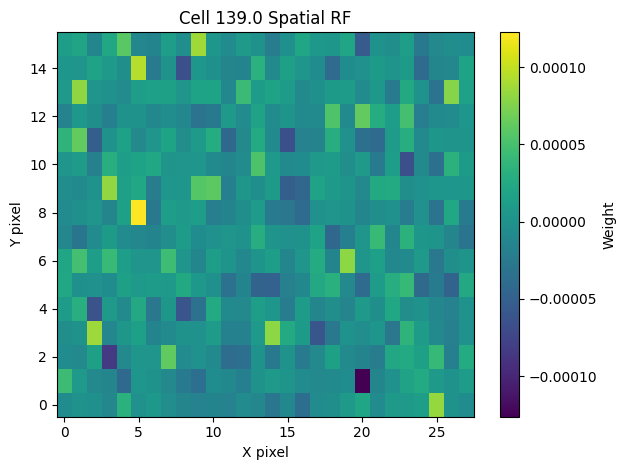

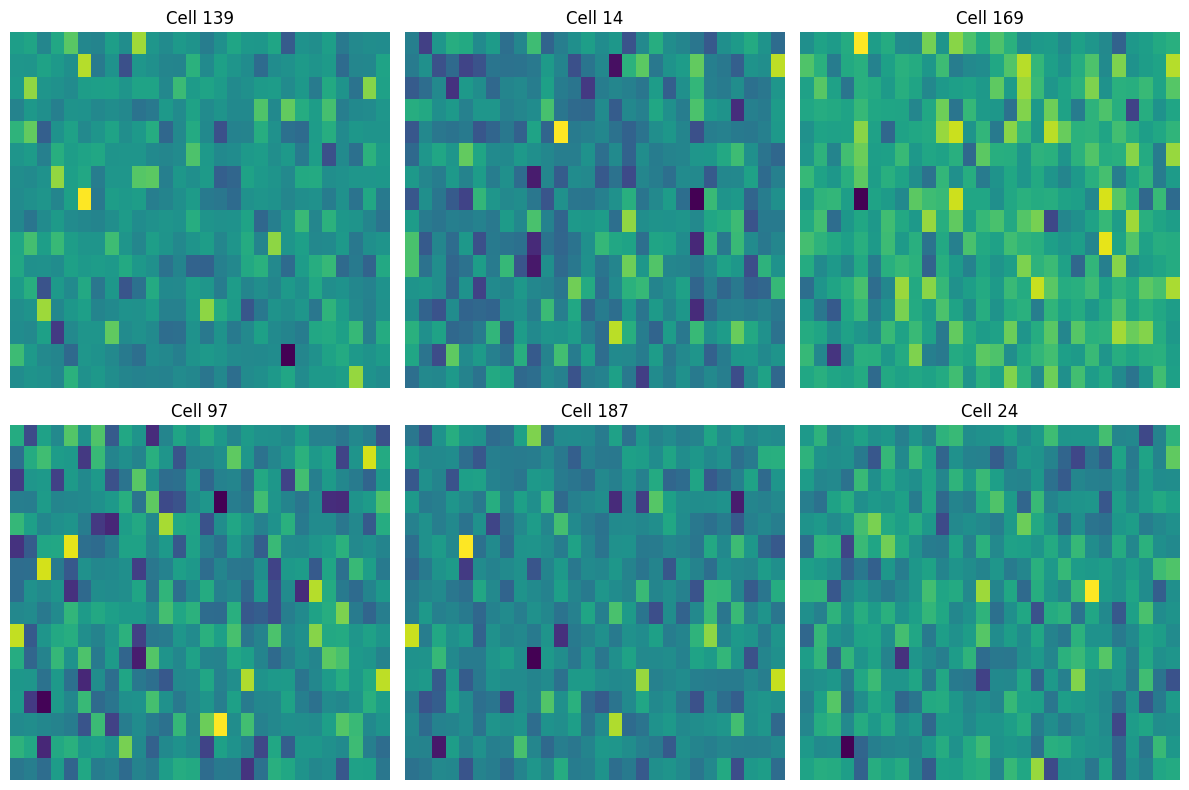

In [50]:
# Plot the best-performing cell
best_cell = data_dict['ln_evaluation'].iloc[0]['cell']
plot_spatial_rf(best_cell, data_dict['rf_spatials'])

# Plot a grid of the top 6 cells
top_cells = data_dict['ln_evaluation'].head(6)['cell'].tolist()
plot_rf_grid(top_cells, data_dict['rf_spatials'], ncols=3)


In [38]:
import numpy as np
import pandas as pd
import pprint

def summarize_data_dict(data_dict, max_head=5):
    """
    For each key in data_dict, print:
      - shape (if array/tensor-like) or len
      - dtype (if available)
      - for numeric arrays: min, max, mean
      - for pandas DataFrames: head
      - for Python sequences: first few items
    """
    for key, val in data_dict.items():
        print(f"\n=== {key} ===")
        # Shape / length
        if hasattr(val, 'shape'):
            print("Shape:", val.shape)
        else:
            try:
                print("Length:", len(val))
            except Exception:
                pass

        # Dtype
        if hasattr(val, 'dtype'):
            print("Dtype:", val.dtype)

        # Numeric array summary
        if isinstance(val, (np.ndarray,)) or (hasattr(val, 'min') and hasattr(val, 'max')):
            try:
                arr = np.array(val).ravel().astype(float)
                print(f"Min: {arr.min():.3g}, Max: {arr.max():.3g}, Mean: {arr.mean():.3g}")
            except Exception:
                pass

        # Pandas DataFrame preview
        if isinstance(val, pd.DataFrame):
            print("DataFrame head:")
            print(val.head(max_head))

        # Pandas Series preview
        elif isinstance(val, pd.Series):
            print("Series head:")
            print(val.head(max_head))

        # Python sequence preview
        elif isinstance(val, (list, tuple)):
            preview = val[:max_head]
            print(f"First {len(preview)} elements:", preview)

        # dict preview
        elif isinstance(val, dict):
            subkeys = list(val.keys())[:max_head]
            print(f"Dict with {len(val)} keys, first keys:", subkeys)

# Usage
summarize_data_dict(data_dict)



=== dff ===
Shape: (189, 105968)
Dtype: float32
Min: -0.574, Max: 10.7, Mean: 0.0194

=== t ===
Shape: (105968,)
Dtype: float64
Min: 9.33, Max: 3.52e+03, Mean: 1.77e+03

=== stim ===
Shape: (9000, 16, 28)
Dtype: uint8
Min: 0, Max: 255, Mean: 127

=== stim_table ===
Shape: (8880, 3)
Dtype: int64
Min: 0, Max: 1.06e+05, Mean: 3.73e+04

=== stim_epoch_table ===
Shape: (7, 3)
Dtype: object

=== roi_masks ===
Shape: (189, 512, 512)
Dtype: uint8
Min: 0, Max: 1, Mean: 0.000754

=== max_projection ===
Shape: (512, 512)
Dtype: uint16
Min: 93, Max: 3.56e+03, Mean: 498

=== running_speed ===
Shape: (2, 105968)
Dtype: float64
Min: nan, Max: nan, Mean: nan

=== mask_sparse ===
Shape: (105968,)
Dtype: bool
Min: 0, Max: 1, Mean: 0.632

=== dff_sparse ===
Shape: (189, 66981)
Dtype: float32
Min: -0.574, Max: 10.7, Mean: 0.0186

=== t_sparse ===
Shape: (66981,)
Dtype: float64
Min: 33.8, Max: 3.52e+03, Mean: 1.79e+03

=== var_raw ===
Shape: (189,)
Dtype: float32
Min: 0.00133, Max: 1.04, Mean: 0.0349

===

In [10]:
import numpy as np

n_cells      = data['oas_s_opt'].shape[0]
spike_counts = np.array([
    np.round(data['oas_s_opt'][i]).astype(int).sum()
    for i in range(n_cells)
])

min_spikes         = 50
good_sta_cells     = np.where(spike_counts >= min_spikes)[0].tolist()
data['good_sta_cells'] = good_sta_cells

print(f"{len(good_sta_cells)}/{n_cells} cells have ≥{min_spikes} spikes "
      f"(median = {np.median(spike_counts):.0f})")
# also store pre_frames for later
data['pre_frames'] = 7


73/189 cells have ≥50 spikes (median = 23)


In [11]:
from utils import compute_sta
import numpy as np
from tqdm.notebook import tqdm

pre_frames = data['pre_frames']
baseline   = 127.0
good_cells = data['good_sta_cells']

sta_all      = {}
rf_map_all   = {}
rf_count_all = {}

for cell in tqdm(good_cells, desc="Computing STAs"):
    spikes_int = np.round(data['oas_s_opt'][cell]).astype(int)
    sta, rf_map, count = compute_sta(
        stim       = data['stim'],
        stim_id    = data['stim_id_clean'],
        spikes     = spikes_int,
        pre_frames = pre_frames,
        baseline   = baseline
    )
    sta_all[cell]      = sta
    rf_map_all[cell]   = rf_map
    rf_count_all[cell] = count

data['sta_all']      = sta_all
data['rf_map_all']   = rf_map_all
data['rf_count_all'] = rf_count_all

counts = np.array(list(rf_count_all.values()))
print(f"STA frame‐counts: {counts.min()} → {counts.max()}")


Computing STAs:   0%|          | 0/73 [00:00<?, ?it/s]

STA frame‐counts: 284 → 55627


In [12]:
import numpy as np

pre_frames  = data['pre_frames']
rf_map_peak = {}

for cell in data['good_sta_cells']:
    sta = data['sta_all'][cell]                          # (pre_frames, H, W)
    mag = np.max(np.abs(sta).reshape(pre_frames, -1), axis=1)
    peak_t = np.argmax(mag)
    rf_map_peak[cell] = sta[peak_t]                      # (H, W)

data['rf_map_peak'] = rf_map_peak

dr = [m.max()-m.min() for m in rf_map_peak.values()]
print(f"Peak‑map dynamic range: {np.min(dr):.1f} → {np.max(dr):.1f}")


Peak‑map dynamic range: 4.6 → 70.0


In [13]:
from utils import fit_2d_gaussian
from tqdm.notebook import tqdm

rf_params_peak = {}
for cell, rf in tqdm(data['rf_map_peak'].items(), desc="Gaussian fit"):
    if np.all(rf == 0):
        continue
    rf_params_peak[cell] = fit_2d_gaussian(rf)

data['rf_params_peak'] = rf_params_peak
print(f"Fitted {len(rf_params_peak)}/{len(data['rf_map_peak'])} peak maps")


Gaussian fit:   0%|          | 0/73 [00:00<?, ?it/s]

Fitted 73/73 peak maps


In [14]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from utils import eval_gaussian

r2_peak  = {}
mse_peak = {}

for cell, params in data['rf_params_peak'].items():
    rf = data['rf_map_peak'][cell]
    model = eval_gaussian(params, rf.shape)

    H, W = rf.shape
    xs, ys = np.meshgrid(np.arange(W), np.arange(H))
    r_sigma = 2 * max(params['sigma_x'], params['sigma_y'])
    mask = ((xs - params['x0'])**2 + (ys - params['y0'])**2) <= r_sigma**2

    y_true = rf[mask]
    y_pred = model[mask]
    r2_peak[cell]  = r2_score(y_true, y_pred)
    mse_peak[cell] = mean_squared_error(y_true, y_pred)

data['rf_fit_r2_peak_masked']  = r2_peak
data['rf_fit_mse_peak_masked'] = mse_peak

print("Masked R²: mean={:.2f}, std={:.2f}".format(
    np.mean(list(r2_peak.values())),
    np.std(list(r2_peak.values()))
))


Masked R²: mean=-2.95, std=3.57


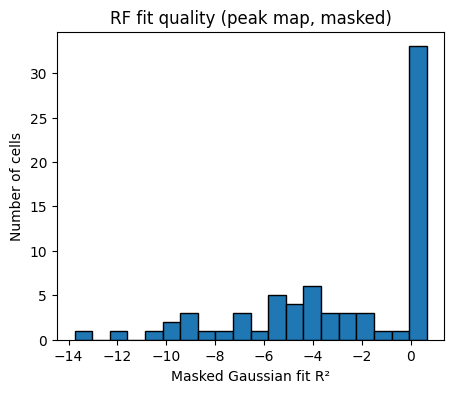

Top 5 by R²:
 cell       R2       MSE
  144 0.663545  4.491756
   71 0.317509  0.599874
  107 0.310366 20.431254
   20 0.258219 11.163684
  142 0.230689  3.218003

Bottom 5 by R²:
 cell         R2        MSE
   27  -9.453863 275.887669
   84  -9.885556  82.971481
  161 -10.169125 129.715564
  115 -11.866336 247.698182
  139 -13.755214 363.733550


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'cell': list(r2_peak.keys()),
    'R2':   list(r2_peak.values()),
    'MSE':  [mse_peak[c] for c in r2_peak.keys()]
})
df = df.sort_values('R2', ascending=False).reset_index(drop=True)

plt.figure(figsize=(5,4))
plt.hist(df['R2'], bins=20, edgecolor='k')
plt.xlabel('Masked Gaussian fit R²')
plt.ylabel('Number of cells')
plt.title('RF fit quality (peak map, masked)')
plt.show()

print("Top 5 by R²:")
print(df.head(5).to_string(index=False))
print("\nBottom 5 by R²:")
print(df.tail(5).to_string(index=False))


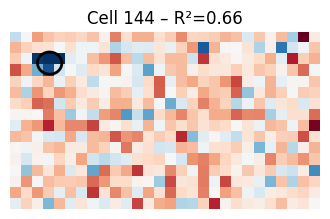

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

best = df.loc[0,'cell']
rf   = data['rf_map_peak'][best]
prm  = data['rf_params_peak'][best]
r2v  = r2_peak[best]

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(rf, cmap='RdBu_r', origin='lower')
ell = Ellipse(
    (prm['x0'], prm['y0']),
    width  = 2*prm['sigma_x'],
    height = 2*prm['sigma_y'],
    angle  = np.degrees(prm['theta']),
    edgecolor='black', facecolor='none', lw=2
)
ax.add_patch(ell)
ax.set_title(f"Cell {best} – R²={r2v:.2f}")
ax.axis('off')
plt.show()


In [17]:
from sklearn.metrics import r2_score
full_r2 = {
    c: r2_score(
         data['rf_map_peak'][c].ravel(),
         eval_gaussian(data['rf_params_peak'][c], data['rf_map_peak'][c].shape).ravel()
       )
    for c in data['rf_params_peak']
}
print("Full‐map R²  mean±std = "
      f"{np.mean(list(full_r2.values())):.2f} ± {np.std(list(full_r2.values())):.2f}")


Full‐map R²  mean±std = -10.05 ± 12.39


In [12]:
from scipy.ndimage import gaussian_filter
from scipy.stats    import pearsonr
import numpy as np

# for each cell in data['good_sta_cells']:
rf0 = data['rf_map_peak'][cell]

# 1) demean
rf1 = rf0 - np.mean(rf0)

# 2) select polarity
amp = rf1.sum()
rf2 = np.where(amp>0, np.clip(rf1, 0, None), np.clip(rf1, None, 0))

# 3) blur
rf3 = gaussian_filter(rf2, sigma=1.0)

# 4) fit
params = fit_2d_gaussian(rf3)
model0 = eval_gaussian(params, rf0.shape)

# 5) build mask (2σ + top 5%)
H,W = rf0.shape
xs, ys = np.meshgrid(np.arange(W), np.arange(H))
r_sigma = 2*max(params['sigma_x'],params['sigma_y'])
circ = ((xs-params['x0'])**2 + (ys-params['y0'])**2) <= r_sigma**2
thr = np.percentile(np.abs(rf3), 95)
mask = circ & (np.abs(rf3)>=thr)

# 6) metrics
y_true = rf0[mask]
y_pred = model0[mask]
r, _   = pearsonr(y_true, y_pred)
data

ValueError: x and y must have length at least 2.

In [13]:
# Robust STA→RF extraction & Gaussian fit (all in one cell)
from utils import compute_sta, fit_2d_gaussian, eval_gaussian
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

# Parameters
min_spikes    = 200       # Minimum events per cell
pre_frames    = 7         # STA window
baseline      = 127.0     # Stimulus centering
top_lags      = 3         # Aggregate top-N strongest lags
smooth_sigma  = 1.0       # Gaussian blur
corr_threshold = 0.3      # Fit quality cutoff

# 1) Identify high-spike cells
n_cells = data['oas_s_opt'].shape[0]
spike_counts = np.array([np.round(data['oas_s_opt'][i]).astype(int).sum() 
                         for i in range(n_cells)])
good_sta_cells = np.where(spike_counts >= min_spikes)[0]
print(f"Computing RFs for {len(good_sta_cells)}/{n_cells} cells (≥{min_spikes} spikes)")

# 2) Compute STAs and build peak maps
rf_maps = {}
for cell in tqdm(good_sta_cells, desc="STA & peak maps"):
    spikes_int = np.round(data['oas_s_opt'][cell]).astype(int)
    sta, _, count = compute_sta(
        stim=data['stim'],
        stim_id=data['stim_id_clean'],
        spikes=spikes_int,
        pre_frames=pre_frames,
        baseline=baseline
    )
    # Sum top-N strongest frames rather than a single lag
    mag = np.max(np.abs(sta).reshape(pre_frames, -1), axis=1)
    top_idx = np.argsort(mag)[-top_lags:]
    peak_map = np.sum(sta[top_idx], axis=0)
    rf_maps[cell] = peak_map

# 3) Fit & evaluate Gaussian per cell
results = []
for cell, rf0 in rf_maps.items():
    # Demean
    rf1 = rf0 - rf0.mean()
    # Polarity mask: keep only sign of net ON/OFF
    amp = rf1.sum()
    rf2 = rf1.clip(min=0) if amp>0 else rf1.clip(max=0)
    # Smooth
    rf3 = gaussian_filter(rf2, sigma=smooth_sigma)
    # Fit Gaussian
    prm = fit_2d_gaussian(rf3)
    model = eval_gaussian(prm, rf0.shape)
    # Mask region: full 2σ circle around center
    H, W = rf0.shape
    xs, ys = np.meshgrid(np.arange(W), np.arange(H))
    r_sigma = 2*max(prm['sigma_x'], prm['sigma_y'])
    mask = (xs-prm['x0'])**2 + (ys-prm['y0'])**2 <= r_sigma**2
    # Compute Pearson r on masked region
    y_true = rf0[mask]
    y_pred = model[mask]
    if y_true.size < 10:
        corr = np.nan
    else:
        corr, _ = pearsonr(y_true, y_pred)
    results.append({'cell':int(cell), 'corr':corr})

# 4) Compile and select well-fit cells
df_rf = pd.DataFrame(results).set_index('cell')
print(df_rf['corr'].describe())

# Threshold
good_rf = df_rf.index[df_rf['corr'] >= corr_threshold].tolist()
print(f"Selected {len(good_rf)}/{len(df_rf)} cells with corr ≥ {corr_threshold}")

# Save
data['good_rf_cells'] = good_rf
data

Computing RFs for 32/189 cells (≥200 spikes)


STA & peak maps:   0%|          | 0/32 [00:00<?, ?it/s]

count    32.000000
mean      0.184005
std       0.148863
min       0.047248
25%       0.120962
50%       0.144014
75%       0.183333
max       0.831910
Name: corr, dtype: float64
Selected 3/32 cells with corr ≥ 0.3


{'dff': array([[0.18523291, 0.22521365, 0.15662627, ..., 0.12980926, 0.22385855,
         0.20101474],
        [0.16234137, 0.19563715, 0.09819604, ..., 0.05814588, 0.16424954,
         0.13883777],
        [0.25420046, 0.09492928, 0.08878411, ..., 0.01382907, 0.07531496,
         0.10702039],
        ...,
        [0.2853903 , 0.11622677, 0.23714365, ..., 0.14905313, 0.18771276,
         0.05753416],
        [0.28776762, 0.21889563, 0.28706336, ..., 0.01415547, 0.01443406,
         0.09131528],
        [0.25064704, 0.08025383, 0.19734518, ..., 0.32296655, 0.3207836 ,
         0.45805585]], dtype=float32),
 't': array([   9.33015,    9.36332,    9.39649, ..., 3524.51876, 3524.55193,
        3524.5851 ]),
 'stim': array([[[127, 127, 127, ..., 127, 127, 127],
         [127, 127, 127, ..., 127, 127, 127],
         [  0, 127, 127, ..., 127, 127, 127],
         ...,
         [127, 127, 127, ..., 127, 127, 127],
         [127, 127, 127, ..., 127, 127, 127],
         [127, 127, 127, ..., 127, 

In [44]:
# import os

# # Make sure the directory exists
# out_dir = 'data/preprocessed'
# os.makedirs(out_dir, exist_ok=True)

# # Good descriptive filename
# fname = 'rf_pipeline_results.npz'
# save_path = os.path.join(out_dir, fname)

# # Save the key analysis outputs
# np.savez_compressed(
#     save_path,
#     sta_all      = data['sta_all'],      # time‐resolved STAs
#     rf_map_all   = data['rf_map_all'],   # summed RF maps
#     rf_count_all = data['rf_count_all'], # frame counts per cell
#     rf_params_all= data['rf_params_all'],# Gaussian fit params per cell
#     cv_results   = data['cv_results'],   # odd/even cross‐val results
# )

# print(f"Preprocessed RF results saved to: {save_path}")


## Step 5: Spatial‑Structure Analysis & Covariate Control

## 5.1 Prepare RF centers & stimulus window

In [45]:

# Gather RF‐center coordinates in stimulus‐pixel units
params    = data['rf_params_all']
pts       = np.vstack([[p['x0'], p['y0']] for p in params.values()])  # shape (N,2)

# Stimulus grid dimensions
H_stim, W_stim = data['stim'].shape[1:]    # e.g. (16, 28)
area_stim     = H_stim * W_stim

# Radii vector
radii = np.linspace(0, min(H_stim, W_stim)/2, 50)

# Save for later
data.update({
    'pts': pts,
    'H_stim': H_stim,
    'W_stim': W_stim,
    'area_stim': area_stim,
    'ripley_radii': radii
})


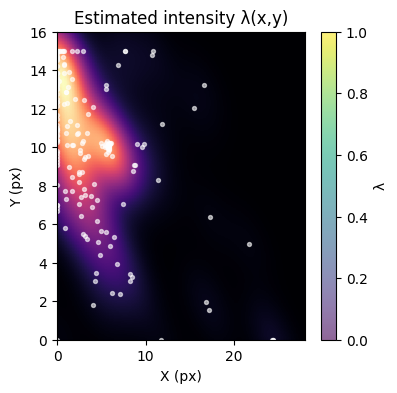

In [46]:
## 5.2 Estimate spatial intensity λ(x,y) via KDE
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

pts_T = pts.T  # shape (2, N)
kde   = gaussian_kde(pts_T)

# Evaluate KDE on a fine grid
xi = np.linspace(0, W_stim, 100)
yi = np.linspace(0, H_stim, 100)
XX, YY = np.meshgrid(xi, yi)
grid_coords = np.vstack([XX.ravel(), YY.ravel()])

density_grid = kde(grid_coords).reshape(XX.shape)

# Intensity at each RF center
lambda_pts = kde(pts_T)

# Save
data['kde']         = kde
data['density_grid']= density_grid
data['xi'], data['yi'] = xi, yi
data['lambda_pts']  = lambda_pts

# Quick visualization
plt.figure(figsize=(4,4))
plt.imshow(density_grid, origin='lower',
           extent=[0, W_stim, 0, H_stim],
           aspect='auto', cmap='magma')
plt.scatter(pts[:,0], pts[:,1], c='white', s=8, alpha=0.6)
plt.title('Estimated intensity λ(x,y)')
plt.xlabel('X (px)'); plt.ylabel('Y (px)')
plt.colorbar(label='λ')
plt.show()

In [47]:
## 5.3 Compute **inhomogeneous** Ripley’s Kₙₕₒₘ(r)
from utils import compute_k_inhomogeneous

K_inhom = compute_k_inhomogeneous(pts, radii, area_stim, lambda_pts)
data['ripley_K_inhom'] = K_inhom


In [49]:
## 5.4 Simulate **inhomogeneous** Poisson null & envelope
from utils import simulate_inhom_poisson_k

n_sims = 500
sims = simulate_inhom_poisson_k(len(pts), (H_stim,W_stim), radii, kde, n_sims)

K_null_mean  = sims.mean(0)
K_null_lower = np.percentile(sims, 2.5, axis=0)
K_null_upper = np.percentile(sims, 97.5, axis=0)

data.update({
    'K_inhom_null_mean':  K_null_mean,
    'K_inhom_null_lower': K_null_lower,
    'K_inhom_null_upper': K_null_upper
})

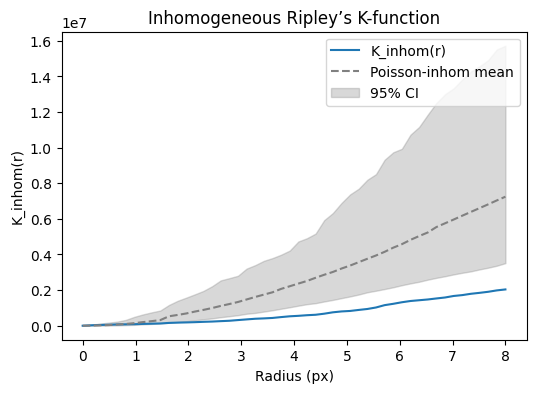

In [50]:
## 5.5 Plot **inhomogeneous** Kₙₕₒₘ(r) with envelope

r = radii
Ki = data['ripley_K_inhom']
km = data['K_inhom_null_mean']
kl = data['K_inhom_null_lower']
ku = data['K_inhom_null_upper']

plt.figure(figsize=(6,4))
plt.plot(r, Ki, label='K_inhom(r)', color='C0')
plt.plot(r, km, '--',   label='Poisson‐inhom mean', color='gray')
plt.fill_between(r, kl, ku, color='gray', alpha=0.3, label='95% CI')
plt.xlabel('Radius (px)')
plt.ylabel('K_inhom(r)')
plt.title('Inhomogeneous Ripley’s K-function')
plt.legend()
plt.show()



In [56]:
# ─── Cell 5.6: Covariate regression & residual RF centers (with progress tracking) ────────────────

import numpy as np
import statsmodels.api as sm
from tqdm.notebook import tqdm

# 1) Load deconvolved spikes
spikes     = data['oas_s_opt']      # shape (n_cells, n_sparse_timepoints)
n_cells, T = spikes.shape

# 2) Interpolate running speed onto t_sparse axis
speed_sparse = np.interp(
    data['t_sparse'],
    data['run_t'],
    data['run_speed']
)
speed = np.nan_to_num(speed_sparse, nan=0.0, posinf=0.0, neginf=0.0)
print(f"[5.6] Interpolated speed shape: {speed.shape}, mean={speed.mean():.3f}, std={speed.std():.3f}")

# 3) Fit Poisson GLM per cell & compute residual trains
resid_trains = np.zeros_like(spikes)
for i in tqdm(range(n_cells), desc="5.6 GLM residuals"):
    y = spikes[i]
    X = sm.add_constant(speed)   # design matrix with intercept + speed
    glm = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    mu  = glm.predict(X)
    resid_trains[i] = y - mu
print(f"[5.6] Completed GLM fits for {n_cells} cells.")

# 4) Recompute RF centers from residuals
new_params = {}
for i in tqdm(range(n_cells), desc="5.6 Recompute RF"):
    sta, rf_map, _ = compute_sta(
        data['stim'],
        data['stim_id_clean'],
        resid_trains[i],
        pre_frames,
        baseline
    )
    new_params[i] = fit_2d_gaussian(rf_map)
print(f"[5.6] Recomputed RF centers for {n_cells} cells.")

# 5) Store residual RF‐center points
pts_resid = np.vstack([[p['x0'], p['y0']] for p in new_params.values()])
data['pts_resid'] = pts_resid
print(f"[5.6] Stored pts_resid with shape: {pts_resid.shape}")

# (Optional) rerun Cells 5.3–5.5 on `pts_resid` to see how clustering changes.


[5.6] Interpolated speed shape: (66981,), mean=3.680, std=8.493


5.6 GLM residuals:   0%|          | 0/189 [00:00<?, ?it/s]

[5.6] Completed GLM fits for 189 cells.


5.6 Recompute RF:   0%|          | 0/189 [00:00<?, ?it/s]

[5.6] Recomputed RF centers for 189 cells.
[5.6] Stored pts_resid with shape: (189, 2)


In [58]:
### 5.7 Compute inhomogeneous K on residual RF centers
# reuse the same radii, area, and null envelope
r    = data['ripley_radii']
area = data['area_stim']
kde  = data['kde']

# 1) empirical inhom K before vs. after
K_before = data['ripley_K_inhom']
K_after  = compute_k_inhomogeneous(data['pts_resid'], r, area, data['lambda_pts'])

# 2) reuse null simulations
K_null_mean  = data['K_inhom_null_mean']
K_null_lower = data['K_inhom_null_lower']
K_null_upper = data['K_inhom_null_upper']

# Store for plotting
data['K_inhom_after'] = K_after


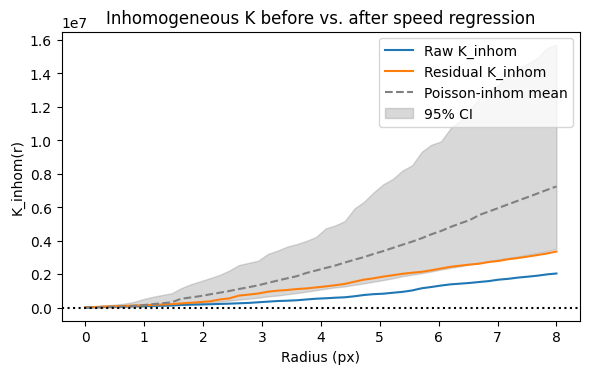

In [59]:
### 5.8 Plot inhomogeneous K before & after covariate regression
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(r, K_before, label='Raw K_inhom',   linewidth=1.5)
plt.plot(r, K_after,  label='Residual K_inhom', linewidth=1.5)
plt.plot(r, K_null_mean, '--', color='gray', label='Poisson‐inhom mean')
plt.fill_between(r, K_null_lower, K_null_upper, color='gray', alpha=0.3, label='95% CI')
plt.axhline(area_stim, color='k', linestyle=':')  # expectation line at area for K
plt.xlabel('Radius (px)')
plt.ylabel('K_inhom(r)')
plt.title('Inhomogeneous K before vs. after speed regression')
plt.legend()
plt.tight_layout()
plt.show()


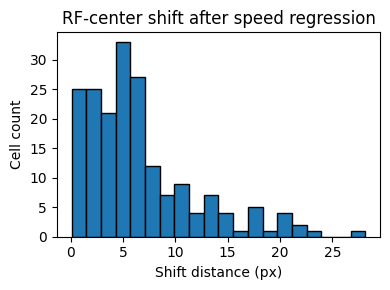

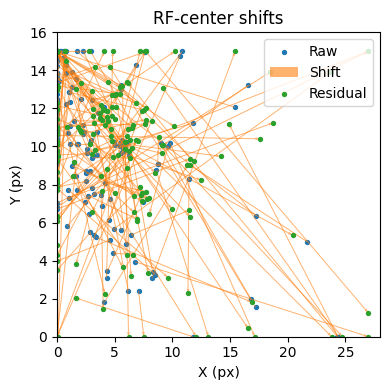

Mean shift = 6.61 px  (max = 28.16 px)


In [60]:
### 5.9 RF‐center shifts: distances & vector plot

# original and residual centers
pts_raw   = data['pts']
pts_res   = data['pts_resid']

# compute shifts
shifts = pts_res - pts_raw
dists  = np.linalg.norm(shifts, axis=1)

# 1) histogram of shift distances
plt.figure(figsize=(4,3))
plt.hist(dists, bins=20, edgecolor='k')
plt.xlabel('Shift distance (px)')
plt.ylabel('Cell count')
plt.title('RF‐center shift after speed regression')
plt.tight_layout()
plt.show()

# 2) vector field overlaid on stimulus grid
plt.figure(figsize=(4,4))
plt.scatter(pts_raw[:,0], pts_raw[:,1], c='C0', s=8, label='Raw')
plt.quiver(pts_raw[:,0], pts_raw[:,1],
           shifts[:,0], shifts[:,1],
           angles='xy', scale_units='xy', scale=1, width=0.003, color='C1', alpha=0.6, label='Shift')
plt.scatter(pts_res[:,0], pts_res[:,1], c='C2', s=8, label='Residual')
plt.xlim(0, W_stim); plt.ylim(0, H_stim)
plt.xlabel('X (px)'); plt.ylabel('Y (px)')
plt.title('RF‐center shifts')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Mean shift = {dists.mean():.2f} px  (max = {dists.max():.2f} px)")


Cell 10: used 352127 stimulus frames for STA


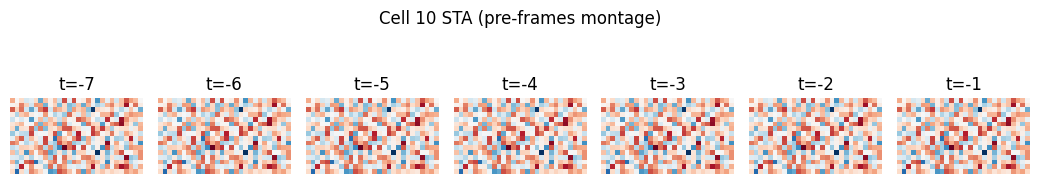

In [82]:
# ─── Exemplar STA animation & montage ────────────────────────────────────

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 1) Pick an exemplar cell
i = 10

# 2) Unpack from your data dicts
sta    = data['sta_all'][i]      # shape (pre_frames, H, W)
rf_map = data['rf_map_all'][i]   # shape (H, W)
count  = data['rf_count_all'][i] # scalar

print(f"Cell {i}: used {count} stimulus frames for STA")

# 3) Animate the STA movie
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
vmin, vmax = sta.min(), sta.max()
ims = [
    [ax.imshow(sta[t], animated=True, vmin=vmin, vmax=vmax, cmap='RdBu')]
    for t in range(sta.shape[0])
]
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)
plt.close(fig)

# Display inline
HTML(ani.to_jshtml())

# 4) Montage of all frames
fig, axes = plt.subplots(1, sta.shape[0], figsize=(sta.shape[0]*1.5, 2))
for t, ax in enumerate(axes):
    ax.imshow(sta[t], cmap='RdBu', vmin=vmin, vmax=vmax)
    ax.set_title(f"t={-(sta.shape[0]-t)}")
    ax.axis('off')
plt.suptitle(f"Cell {i} STA (pre‐frames montage)", y=1.05)
plt.tight_layout()
plt.show()


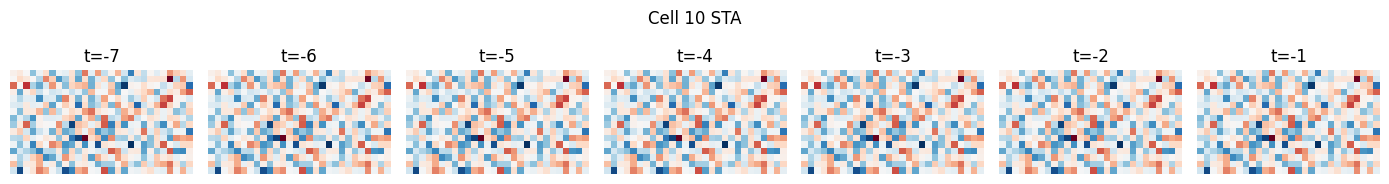

In [62]:
# Montage all STA frames as small subplots
fig, axes = plt.subplots(1, sta.shape[0], figsize=(sta.shape[0]*2,2))
for t, ax in enumerate(axes):
    ax.imshow(sta[t], cmap='RdBu', vmin=sta.min(), vmax=sta.max())
    ax.set_title(f"t={- (sta.shape[0]-t)}")
    ax.axis('off')
plt.suptitle(f"Cell {i} STA")
plt.tight_layout()


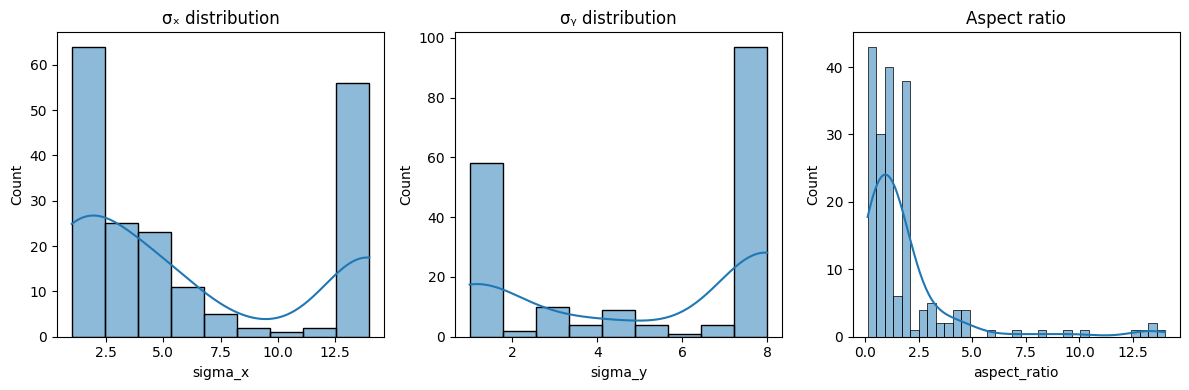

In [63]:

import pandas as pd, seaborn as sns

# build DataFrame of parameters
df = pd.DataFrame(data['rf_params_all']).T
df['area'] = np.pi * df['sigma_x'] * df['sigma_y']
df['aspect_ratio'] = df['sigma_x'] / df['sigma_y']

# Histograms
fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(df['sigma_x'], ax=axs[0], kde=True).set_title('σₓ distribution')
sns.histplot(df['sigma_y'], ax=axs[1], kde=True).set_title('σᵧ distribution')
sns.histplot(df['aspect_ratio'], ax=axs[2], kde=True).set_title('Aspect ratio')
plt.tight_layout()


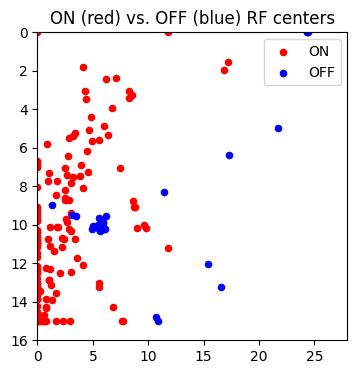

In [64]:
# split by sign of amplitude
params = data['rf_params_all']
pts = np.array([[p['x0'],p['y0']] for p in params.values()])
amps = np.array([p['amplitude'] for p in params.values()])
on  = pts[amps>0]
off = pts[amps<0]

plt.figure(figsize=(4,4))
plt.scatter(on[:,0],  on[:,1],  c='r', s=20, label='ON')
plt.scatter(off[:,0], off[:,1], c='b', s=20, label='OFF')
plt.legend()
plt.title('ON (red) vs. OFF (blue) RF centers')
plt.xlim(0, W_stim); plt.ylim(0, H_stim)
plt.gca().invert_yaxis()
plt.show()


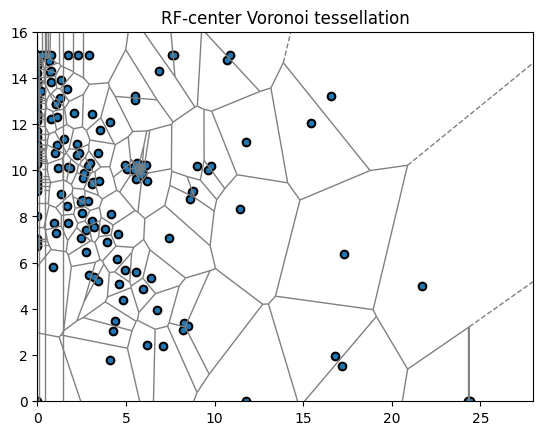

In [65]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(pts)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='gray')
plt.scatter(pts[:,0], pts[:,1], c='k')
plt.title('RF‐center Voronoi tessellation')
plt.xlim(0, W_stim); plt.ylim(0, H_stim)
plt.show()


Using cell 0 for STC (eigvals = [394575.86220684 168352.67845159])


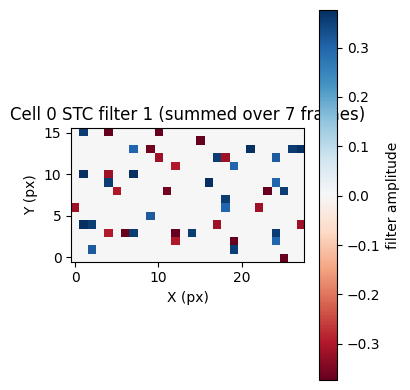

In [80]:
# ─── Choosing a good cell with enough spikes for STC ─────────────────────

from utils import compute_stc
import matplotlib.pyplot as plt

pre_frames = 7
baseline   = 127.0

# 1) Get the list of cells that passed CV (or QC)
good_cells = data.get('good_cells_cv', data['good_cells'])

# 2) Search for the first cell with enough spikes to run STC
chosen = None
for cell in good_cells:
    eigvals, eigvecs = compute_stc(
        data['stim'],
        data['stim_id_clean'],
        data['oas_s_opt'][cell],
        pre_frames=pre_frames,
        baseline=baseline,
        n_components=2
    )
    if eigvals.size > 0:
        chosen = cell
        break

if chosen is None:
    raise RuntimeError("No good cell had enough spikes for STC. Try lowering pre_frames or using a different list.")
else:
    print(f"Using cell {chosen} for STC (eigvals = {eigvals})")

# 3) Visualize the first STC filter for the chosen cell
H_stim, W_stim = data['stim'].shape[1:]
stc1 = eigvecs[:,0].reshape(pre_frames, H_stim, W_stim).sum(axis=0)

plt.figure(figsize=(4,4))
plt.imshow(stc1, cmap='RdBu', origin='lower')
plt.title(f"Cell {chosen} STC filter 1 (summed over {pre_frames} frames)")
plt.colorbar(label='filter amplitude')
plt.xlabel('X (px)'); plt.ylabel('Y (px)')
plt.tight_layout()
plt.show()
